# Electrophysiology Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import re

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import ephys_analysis as ep_methods

# Normalized Template Matching Spike Detection Method (2019, Feldman, D.E.)

[A normalized template matching method for improving spike detection in extracellular voltage recordings](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6700190/)

## Standard Fixed-Threshold Method

This method uses a fixed threshold to extract spike signals, as 3 standard deviations above mean and greater than 60mV. Peaks will then be aligned and relevant features extracted. Features will include:

* Number of spikes
* Positive peak amplitude
* Negative spike amplitude (before peak and after peak)
* Spike width (trough before to peak, peak to trough after)

PCA will be used visualize in feature space, with k clusters as determined by Nearest Neighbors Analysis. 

### Pre-Processing Steps

For the cells below: **(above)** extracts signals from single txt file and **(below)** extracts from everything within a folder. Same method used for both, run only one of the two cells.

In [5]:
### Step 0: Extract from a single recording

txt_path='./20220308_1937/V_m1/1-100/220308_004[1-100][Im1,Vm1].txt'
extracted_signals_lst = []

recpath = Path(txt_path) # change the recording path to extract from
extracted_rec = ep_methods.extract_signals(recpath, min_height=20,
                                           signal_duration_after=0.5,
                                           signal_duration_before=0.3)
if len(extracted_rec)>0:
    print(len(extracted_rec))
    extracted_signals_lst.append(extracted_rec) # aggregate extracted signals as list (recordings) of list (rounds) of lists (events in round)


99


In [18]:
### Step 0: Extract signals from entire dataset aggregated into single list

extract_range = Path('./20220427_singleganglion_muscle/recs/lighton').iterdir()
# extract_range = range(16, 19) # select range of recording numbers 
extracted_signals_lst = []

for txt_path in sorted(extract_range): 
    if (txt_path.stem!='.DS_Store') and (txt_path.stem!='notes'):
        print(txt_path.stem)
        recpath = Path(txt_path) # change the recording path to extract from
        extracted_rec = ep_methods.extract_signals(recpath, 
                                                   min_height=60, 
                                                   signal_duration_after=0.4, 
                                                   signal_duration_before=0.1)
        if len(extracted_rec)>0:
            print(len(extracted_rec))
            extracted_signals_lst.append(extracted_rec) # aggregate extracted signals as list (recordings) of list (rounds) of lists (events in round)


220427_004_scopelighton_singlerhop_muscle[1-25][Vm1]
22
220427_005_lighton[1-25][Vm1]
24


In [19]:
### Step 1: Align all peaks 

aligned_peak_df = ep_methods.align_peaks(extracted_signals_lst)

### Feature Extraction

Features to be extracted are:

* Number of peaks
* Positive peak amplitude
* Negative spike amplitude
* Spike width (Note: each is same time interval from each other)


In [20]:
### Step 2: Extract relevant features

feature_df = ep_methods.extract_features(aligned_df=aligned_peak_df, peak_height_multiplier=2)

In [21]:
aligned_peak_df = aligned_peak_df.loc[feature_df.index, :] ### drops all columns dropped from feature extraction

### Clustering: PCA and K-Means (Unsupervised, distance from centroid) vs. K-Nearest Neighbors (Supervised, distance from other classified points)

#### Unsupervised PCA + K-Means:

Use an unsupervised method first to identify unique waveforms of PCA. From there, train KNN based on data clustered by KMeans as training to develop classifier for future test data. 

In [22]:
from sklearn import preprocessing

# Preprocessing: scale to 0 mean and unit variance
scaler = preprocessing.StandardScaler()
scaled_feature_df = scaler.fit_transform(feature_df)


In [23]:
# Run PCA
pca_model = PCA(n_components=3)
pca_model.fit(scaled_feature_df)
pca_df = pca_model.transform(scaled_feature_df)

In [24]:
# KMeans clustering

kmeans = KMeans(n_clusters=5) # perform kmeans again
    
label = kmeans.fit_predict(pca_df) # predict the labels of clusters.
clusters = kmeans.labels_

# set clusters to the peak DF and feature DF
feature_df['cluster'] = clusters
aligned_peak_df['cluster'] = clusters

u_labels = np.unique(label) # Getting unique labels
centroids = kmeans.cluster_centers_

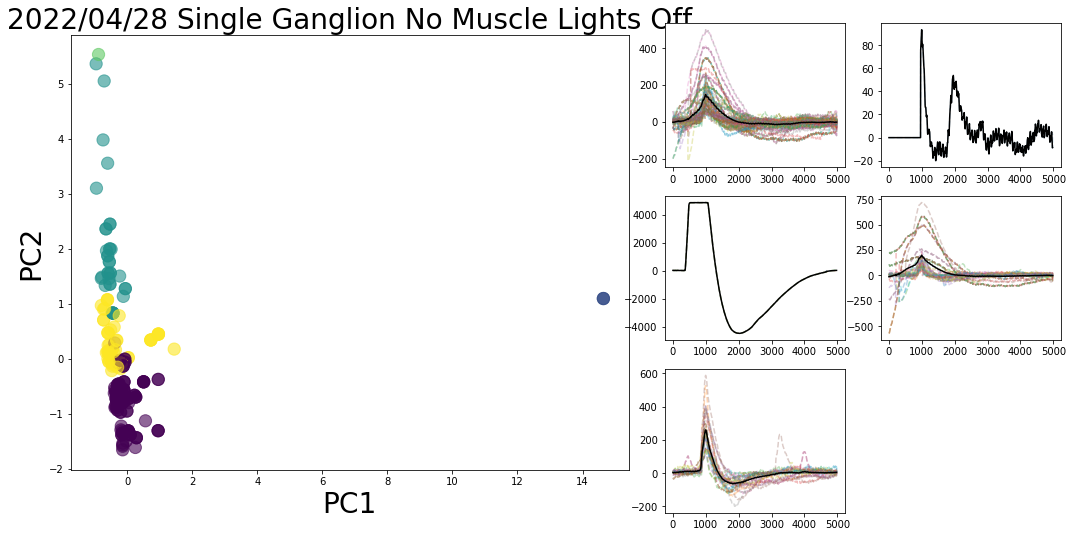

In [25]:
# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(pca_df[:, 0], pca_df[:, 1], c=clusters, s=150, alpha=0.6) # plot PCs

plt.xlabel('PC1', fontsize='28')
plt.ylabel('PC2', fontsize='28')
plt.title('2022/04/28 Single Ganglion No Muscle Lights Off', fontsize='28')

# for i in range(len(pca_df)):
#     plt.annotate(i, (pca_df[:, 0][i], pca_df[:, 1][i]))

# plot cluster 0 
cluster0_ax = plt.axes([0.95, .65, .25, .25], facecolor='white') # change this for locations of averaged plots
cluster0 = aligned_peak_df.loc[aligned_peak_df['cluster']==0].reset_index(drop=True)
cluster0_avg = cluster0.drop('cluster', axis=1).mean(axis=0)
for i in range(len(cluster0)):
    plt.plot(range(len(cluster0.columns)), cluster0.loc[i, :], linestyle='dashed', alpha=0.3)
plt.plot(cluster0_avg.index, cluster0_avg, c='black')

# plot cluster 1 
cluster1_ax = plt.axes([.95, .35, .25, .25], facecolor='white') # change this for locations of averaged plots
cluster1 = aligned_peak_df.loc[aligned_peak_df['cluster']==1].reset_index(drop=True)
cluster1_avg = cluster1.drop('cluster', axis=1).mean(axis=0)
for i in range(len(cluster1)):
    plt.plot(range(len(cluster1.columns)), cluster1.loc[i, :], linestyle='dashed', alpha=0.3)
plt.plot(cluster1_avg.index, cluster1_avg, c='black')
# plt.ylim([-100, 100])

# plot cluster 2 
cluster2_ax = plt.axes([.95, .05, .25, .25], facecolor='white') # change this for locations of averaged plots
cluster2 = aligned_peak_df.loc[aligned_peak_df['cluster']==2].reset_index(drop=True)
cluster2_avg = cluster2.drop('cluster', axis=1).mean(axis=0)
for i in range(len(cluster2)):
    plt.plot(range(len(cluster2.columns)), cluster2.loc[i, :], linestyle='dashed', alpha=0.3)
plt.plot(cluster2_avg.index, cluster2_avg, c='black');

# plot cluster 3 
cluster3_ax = plt.axes([1.25, .65, .25, .25], facecolor='white') # change this for locations of averaged plots
cluster3 = aligned_peak_df.loc[aligned_peak_df['cluster']==3].reset_index(drop=True)
cluster3_avg = cluster3.drop('cluster', axis=1).mean(axis=0)
for i in range(len(cluster3)):
    plt.plot(range(len(cluster3.columns)), cluster3.loc[i, :], linestyle='dashed', alpha=0.3)
plt.plot(cluster3_avg.index, cluster3_avg, c='black')

# plot cluster 4 
cluster4_ax = plt.axes([1.25, .35, .25, .25], facecolor='white') # change this for locations of averaged plots
cluster4 = aligned_peak_df.loc[aligned_peak_df['cluster']==4].reset_index(drop=True)
cluster4_avg = cluster4.drop('cluster', axis=1).mean(axis=0)
for i in range(len(cluster4)):
    plt.plot(range(len(cluster4.columns)), cluster4.loc[i, :], linestyle='dashed', alpha=0.3)
plt.plot(cluster4_avg.index, cluster4_avg, c='black')

# save figure
# plt.savefig('./Figures/20220428/20220428_singlerhop_muscle_lightson_thres60mV_durationpt2ms', bbox_inches='tight', facecolor='white', dpi=500)



#### Supervised PCA + KNN (WIP)

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
pca_model = PCA(n_components=2)
pca_model.fit(X_train)
X_train = pca_model.transform(X_train)
X_test = pca_model.transform(X_test)